In [1]:
import numpy as np
import pandas as pd
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
from config import db_password
import psycopg2


from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
deaths_df = pd.read_csv('../../../data/cleaned_data/cre_svi_death_pct.csv', index_col = 'FIPS')
deaths_df = deaths_df.rename(columns = {'3/31/21':'first_yr_deaths'})
deaths_df

,POPUNI,PRED0_PE,PRED12_PE,PRED3_PE,first_yr_deaths,BEDS,dem_pct,Agreeableness,Belief In Science,Collectivism,...,Hopefulness,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,AREA_SQMI
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,55688,36.94,40.85,22.20,99,85.0,27.018365,86.279655,70.833333,57.142857,...,91.163142,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,594.443459
1003,221898,35.43,40.81,23.76,301,332.0,22.409030,85.603337,63.268161,67.948815,...,82.484017,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,1589.793007
1005,22023,22.81,41.64,35.54,55,74.0,45.788173,87.711609,63.046939,70.099756,...,61.927181,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,885.001636
1007,20393,30.79,44.06,25.14,58,35.0,20.698280,84.830261,63.262028,72.034797,...,85.258871,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,622.461089
1009,57697,31.53,41.51,26.97,131,40.0,9.569378,85.548096,33.333333,80.000000,...,79.492703,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,644.830460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,41888,40.53,42.45,17.02,37,115.0,22.894957,83.811791,68.303853,68.673956,...,82.403142,30945.0,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,10426.975725
56039,23390,31.00,49.45,19.55,9,48.0,66.599040,82.886955,73.489916,63.115088,...,84.036899,46499.0,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,3996.844622
56041,20183,38.37,46.31,15.32,12,42.0,16.819960,84.272810,67.029022,67.552392,...,84.089095,25636.0,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,2081.719807


In [3]:
# #set index to FIPS
# df = df.set_index(df['FIPS'])
# df= df.drop(['FIPS'], axis=1)

In [4]:
# # use regex to split svi columns into distinct categories
# cols = df.columns.to_list()
# col_series = pd.Series(cols)
# pct_str = r'^[ERS]P+.'
# pct_form = col_series.str.contains(pct_str)
# pct_col = col_series[pct_form].to_list()
# flag_str = r'^F+.'
# flag_form = col_series.str.contains(flag_str)
# flag_col = col_series[flag_form].to_list()
# val_str = r'^E_+.'
# val_form = col_series.str.contains(val_str)
# val_col = col_series[val_form].to_list()
# non_svi = col_series[~pct_form & ~flag_form & ~val_form].to_list()

In [5]:
# # filter cases_df to only have svi estimated percentage columns
# deaths_df = df.drop(columns = flag_col)
# deaths_df = deaths_df.drop(columns = val_col)
# deaths_df.columns.to_list()
# deaths_df = deaths_df.merge(df['E_TOTPOP'], how = 'left', left_index=True, right_index=True)


In [6]:
#drop zeros - they may be errors? 
zeros = deaths_df.loc[deaths_df['first_yr_deaths']==0]
deaths_df = deaths_df.drop(index = zeros.index)
deaths_df

,POPUNI,PRED0_PE,PRED12_PE,PRED3_PE,first_yr_deaths,BEDS,dem_pct,Agreeableness,Belief In Science,Collectivism,...,Hopefulness,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,AREA_SQMI
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,55688,36.94,40.85,22.20,99,85.0,27.018365,86.279655,70.833333,57.142857,...,91.163142,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,594.443459
1003,221898,35.43,40.81,23.76,301,332.0,22.409030,85.603337,63.268161,67.948815,...,82.484017,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,1589.793007
1005,22023,22.81,41.64,35.54,55,74.0,45.788173,87.711609,63.046939,70.099756,...,61.927181,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,885.001636
1007,20393,30.79,44.06,25.14,58,35.0,20.698280,84.830261,63.262028,72.034797,...,85.258871,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,622.461089
1009,57697,31.53,41.51,26.97,131,40.0,9.569378,85.548096,33.333333,80.000000,...,79.492703,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,644.830460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,41888,40.53,42.45,17.02,37,115.0,22.894957,83.811791,68.303853,68.673956,...,82.403142,30945.0,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,10426.975725
56039,23390,31.00,49.45,19.55,9,48.0,66.599040,82.886955,73.489916,63.115088,...,84.036899,46499.0,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,3996.844622
56041,20183,38.37,46.31,15.32,12,42.0,16.819960,84.272810,67.029022,67.552392,...,84.089095,25636.0,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,2081.719807


In [7]:
deaths_df['pop_density'] = deaths_df['POPUNI']/deaths_df['AREA_SQMI']

In [8]:
#create variable for death% for each counties population
deaths_df['death_pct'] = deaths_df['first_yr_deaths']/deaths_df['POPUNI']*100
deaths_df['death_pct'].head()

FIPS
1001    0.177776
1003    0.135648
1005    0.249739
1007    0.284411
1009    0.227048
Name: death_pct, dtype: float64

In [9]:
deaths_df['death_pct'].describe()

count    3000.000000
mean        0.197046
std         0.113159
min         0.001390
25%         0.117239
50%         0.178936
75%         0.252381
max         0.865801
Name: death_pct, dtype: float64

## RF Regressor

In [10]:
deaths_df.shape

(3000, 29)

In [11]:
# Define feature set (x)
X = deaths_df.drop(['first_yr_deaths','death_pct','POPUNI','AREA_SQMI'], axis=1).values

#Define (y)
y= deaths_df['death_pct'].values

In [12]:
#split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 ,random_state= 42) 

In [13]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2100, 25)
(900, 25)
(2100,)
(900,)


In [14]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
# evaluate random search 
from sklearn.ensemble import RandomForestRegressor

def evaluate(model, test_features, test_labels):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / len(y_test))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 200, random_state = 42)
base_model = base_model.fit(X_train_scaled, y_train)
base_accuracy = evaluate(base_model, X_test_scaled, y_test)

Model Performance
Average Error: 0.1728 degrees.
Accuracy = 99.98%.


In [16]:
# turn model predictions into dataframe
preds = pd.DataFrame(base_model.predict(X_test_scaled), columns = ['pred'])
preds['pred_rank'] = preds.index
preds.sort_values(by = ['pred'], ascending = False, ignore_index = True, inplace = True)
preds

,pred,pred_rank
0,0.438275,166
1,0.415330,337
2,0.386495,372
3,0.382927,254
4,0.382143,68
...,...,...
895,0.064604,869
896,0.064129,762
897,0.062189,356
898,0.060036,732


In [17]:
#turn test values into dataframe
actuals = pd.DataFrame(y_test, columns = ['act'])
actuals['act_rank'] = actuals.index
actuals.sort_values(by = ['act'],ascending = False, ignore_index = True, inplace =True)
actuals

,act,act_rank
0,0.716846,662
1,0.704225,489
2,0.662589,187
3,0.650195,710
4,0.638613,578
...,...,...
895,0.017095,777
896,0.014209,883
897,0.008065,638
898,0.007495,125


In [18]:
# merege acutal and predicted dataframes
ranked_results = actuals.merge(preds, how = 'inner', left_index=True, right_index=True)
ranked = ranked_results.head(180)
ranked

,act,act_rank,pred,pred_rank
0,0.716846,662,0.438275,166
1,0.704225,489,0.415330,337
2,0.662589,187,0.386495,372
3,0.650195,710,0.382927,254
4,0.638613,578,0.382143,68
...,...,...,...,...
175,0.280261,712,0.235348,828
176,0.279680,97,0.235221,628
177,0.279395,615,0.235219,134
178,0.278818,198,0.235187,393


In [19]:
correct = 0
correct_index = []

for index, row in ranked.iterrows():
    if row['pred_rank'] in ranked['act_rank'].values:
        correct = correct+1
        correct_index.append(row['pred_rank'])
    

In [20]:
correct

93

In [21]:
results = actuals.merge(preds, how = 'inner', left_on='act_rank', right_on='pred_rank')
results

,act,act_rank,pred,pred_rank
0,0.716846,662,0.303255,662
1,0.704225,489,0.186529,489
2,0.662589,187,0.335778,187
3,0.650195,710,0.223770,710
4,0.638613,578,0.240859,578
...,...,...,...,...
895,0.017095,777,0.110492,777
896,0.014209,883,0.213464,883
897,0.008065,638,0.059158,638
898,0.007495,125,0.185002,125


In [22]:
# create columns to display error amounts
results['error'] = results['act']-results['pred']
results['abs_error'] = abs(results['act']-results['pred'])
results

,act,act_rank,pred,pred_rank,error,abs_error
0,0.716846,662,0.303255,662,0.413591,0.413591
1,0.704225,489,0.186529,489,0.517696,0.517696
2,0.662589,187,0.335778,187,0.326811,0.326811
3,0.650195,710,0.223770,710,0.426425,0.426425
4,0.638613,578,0.240859,578,0.397754,0.397754
...,...,...,...,...,...,...
895,0.017095,777,0.110492,777,-0.093397,0.093397
896,0.014209,883,0.213464,883,-0.199256,0.199256
897,0.008065,638,0.059158,638,-0.051093,0.051093
898,0.007495,125,0.185002,125,-0.177506,0.177506


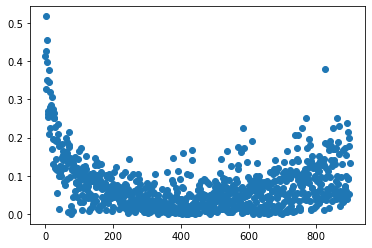

In [23]:
#plot errors
plt.scatter(results.index,results['abs_error'])

In [24]:
#find worst performer
results[results['error']==results['error'].max()]

,act,act_rank,pred,pred_rank,error,abs_error
1,0.704225,489,0.186529,489,0.517696,0.517696


In [25]:
#explore errors
results['error'].describe()

count    900.000000
mean      -0.002324
std        0.098558
min       -0.378341
25%       -0.061997
50%       -0.010067
75%        0.047859
max        0.517696
Name: error, dtype: float64

In [26]:
#explore absolute errors
results['abs_error'].describe()

count    900.000000
mean       0.072411
std        0.066856
min        0.000117
25%        0.023625
50%        0.055076
75%        0.099543
max        0.517696
Name: abs_error, dtype: float64

In [27]:
#explore death percents
results['act'].describe()

count    900.000000
mean       0.194706
std        0.115863
min        0.007141
25%        0.112095
50%        0.175738
75%        0.252518
max        0.716846
Name: act, dtype: float64